# 10: Big Entropy and the Generalized Linear Model
We are going to examine the role of entropy in our choice of distributions to represent our priors/posteriors. The guiding principle here is that we want to choose the distribution that maximizes entropy (uncertainty) given some constraints. Before, we only really used Gaussian distributions, which it turns out are the maximum entropy distribution over the real numbers given a fixed mean and variance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import binom

### Code 10.1 - 10.4
Now we will analyze the role of entropy in choosing a maximum entropy discrete distribution for count data. If we assume we have 10 pebbles that can be split between 5 buckets, how many ways are there to arrange them? How many of these ways end up with the same number of pebbles in each bucket?

In [2]:
# consider 5 different potential orderings of the pebbles
p = {
    "A": [0, 0, 10, 0, 0],
    "B": [0, 1, 8, 1, 0],
    "C": [0, 2, 6, 2, 0],
    "D": [1, 2, 4, 2, 1],
    "E": [2, 2, 2, 2, 2],
}
# normalize
p_norm = {k: np.array(v)/np.sum(v) for k, v in p.items()}

In [3]:
# calculate entropy
H = {k: -(q * np.where(q==0, 0, np.log(q))).sum() for k, q in p_norm.items()}
H

/home/ecotner/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


{'A': -0.0,
 'B': 0.639031859650177,
 'C': 0.9502705392332347,
 'D': 1.4708084763221112,
 'E': 1.6094379124341005}

It turns out that the entropy is highest for the most uniform distribution. How many ways can these counts of pebbles be realized? Well there are $\binom{N}{k}$ ways to sample $k$ identical objects from a pool of $N$. So if we envision looking into each bucket in sequence, we know that for the first bucket, there are $\binom{N}{k_1}$ ways of arranging the pebbles in that bucket, $\binom{N-k_1}{k_2}$ ways of arranging the pebbles in the second bucket (because $k_1$ of the pebbles are already in the first bucket, so there are only $N - k_1$ "free" pebbles left), $\binom{N-(k_1+k_2)}{k_3}$ in the third, etc...

In [4]:
ways = dict()
for k in p:
    n_left = 10
    w = []
    for n in p[k]:
        w.append(binom(n_left, n))
        n_left -= n
    ways[k] = int(np.prod(w))
ways

{'A': 1, 'B': 90, 'C': 1260, 'D': 37800, 'E': 113400}

In [5]:
logwayspp = {k: np.log2(ways[k])/10 for k in ways}
logwayspp

{'A': 0.0,
 'B': 0.6491853096329675,
 'C': 1.029920801838728,
 'D': 1.5206098613995798,
 'E': 1.6791061114716954}

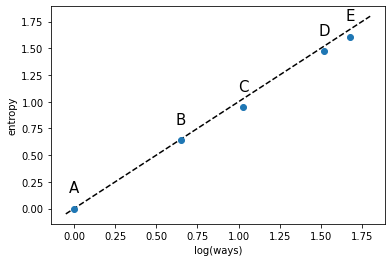

In [6]:
x = np.linspace(-0.05, 1.80, 3)
plt.plot(x, x, color="black", linestyle="--", zorder=-1)
x = list(logwayspp.values())
y = list(H.values())
plt.scatter(x, y)
plt.xlabel("log(ways)")
plt.ylabel("entropy")
labels = list(H.keys())
for i in range(len(labels)):
    plt.text(x[i], y[i]+0.15, labels[i], horizontalalignment="center", fontsize=15)
plt.show()

### Code 10.5 - 10.6
Now we want to compare the entropies of several potential probability distributions for sampling blue and white marbles from a bag, where we _know_ that the expected number of blue marbles over two draws is exactly 1. We consider the following proposal distributions

In [7]:
p = pd.DataFrame([
    [1/4, 1/4, 1/4, 1/4],
    [2/6, 1/6, 1/6, 2/6],
    [1/6, 2/6, 2/6, 1/6],
    [1/8, 4/8, 2/8, 1/8],
], columns=["ww","bw","wb","bb"], index=list("ABCD"))
p

,ww,bw,wb,bb
A,0.250000,0.250000,0.250000,0.250000
B,0.333333,0.166667,0.166667,0.333333
C,0.166667,0.333333,0.333333,0.166667
D,0.125000,0.500000,0.250000,0.125000


In [8]:
# Compute expected value of # of blue marbles
(p*np.array([[0, 1, 1, 2]])).sum(axis=1)

A    1.0
B    1.0
C    1.0
D    1.0
dtype: float64

In [9]:
# compute entropy of each distribution
-(p*np.log(p)).sum(axis=1)

A    1.386294
B    1.329661
C    1.329661
D    1.213008
dtype: float64

We see that distribution A has the largest entropy. It just happens to be the same as the binomal distribution for $b$ successes out of $n=2$ trials.

### Code 10.7 - 10.13
The above example was kind of special because the distribution over outcomes can remain flat and still be consistent with the constraint. What if the expected value was 1.4 marbles in two draws ($p = 0.7$). The binomial distribution with this expected value is

In [10]:
p = 0.7
A = np.array([(1-p)**2, p*(1-p), (1-p)*p, p**2])
A

array([0.09, 0.21, 0.21, 0.49])

In [11]:
# entropy of distribution
-(A*np.log(A)).sum()

1.221728604109787

If we randomly generate a bunch of distributions with the same expected value of 1.4, then we expect that none of them will have a larger entropy than 1.22.

In [12]:
def sim_dists(G=1.4):
    x123 = np.random.rand(3)
    x4 = (G * x123.sum() - x123[1] - x123[2])/(2-G)
    z = x123.sum() + x4
    p = np.array([*x123, x4])/z
    return dict(H=-(p*np.log(p)).sum(), p=p)

H = [sim_dists() for _ in range(10_000)]
entropies = np.array([d["H"] for d in H])
distributions = np.array([d["p"] for d in H])

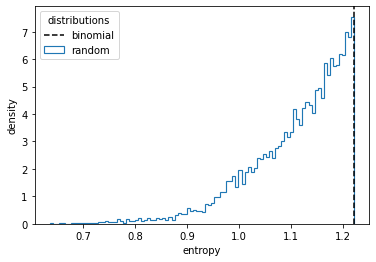

In [13]:
plt.hist(entropies, bins=100, density=True, histtype="step", linewidth=1.15, label="random")
plt.xlabel("entropy")
plt.ylabel("density")
plt.axvline(-(A*np.log(A)).sum(), color="black", linestyle="--", label="binomial")
plt.legend(title="distributions")
plt.show()

We can see that the largest entropy sample has a distribution that is almost identical to the binomial distribution.

In [14]:
idx = np.argmax(entropies)
print("max entropy:", entropies[idx])
print("sample distribution:", distributions[idx])
print("binomial distribution:", A)

max entropy: 1.221705804760178
sample distribution: [0.08953159 0.21253592 0.20840089 0.48953159]
binomial distribution: [0.09 0.21 0.21 0.49]


## Generalized linear models

The rest of the chapter is about generalized linear models (abbreviated GLM). There are no more code snippets, just some general theoretical motivation for their use. The idea is that instead of using the normal distribution and having $\mu$ be a linear function of the predictors, perhaps we could (and in fact _should_) use other distributions in different scenarios, and instead try and predict the parameters that define them as functions of the predictors.

For example, if we have some count data where we need to infer the probability of an even occurring, we could use the following GLM:

$$
\begin{align}
y_i &\sim \text{Binomial}(n, p_i) \\
f(p_i) &= \alpha + \beta x_i
\end{align}
$$

where $f(p)$ is known as the "link function", and its purpose is to transform the range of the linear function $\alpha + \beta x$ into the domain of the parameter $p$. The problem is that $\alpha + \beta x$ can in principle be any real number, but $p \in [0, 1]$. So we need some function to "squash" the range to fit in there. A useful transformation in this case is the logit function
$$\text{logit}(p) = \log \frac{p}{1-p},$$
which amounts to a transformation of
$$p = f^{-1}(\alpha + \beta x) = \frac{\exp(\alpha + \beta x)}{1 + \exp(\alpha + \beta x)}$$
Because this inverse transformation is so common, you'll usually see $f^{-1}$ just as often as you'll see $f$.

The use of a nonlinear link function implicitly leads to interaction effects between all of the predictors because now the derivative of the parameter with respect to one predictor is now a function of all the predictors, not just the one:
$$
\frac{\partial p}{\partial x_i} = (f^{-1})^\prime(\alpha + \beta \cdot x) \beta_i
$$
(I'm assuming $x$ and $\beta$ are both vectors here)